In [13]:
import torch
from torch import nn
import torch.nn.functional as F
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from sklearn.metrics import precision_score, recall_score, f1_score, matthews_corrcoef, roc_auc_score
import numpy as np
import itertools
from itertools import permutations, combinations
import time
from pylab import *

torch.manual_seed(3)                      # reproducible
torch.set_printoptions(threshold=np.inf)  # print all

def findByRow(mat, row):
    return np.where((mat == row).all(1))[0]


# ----- Step 1: Set Hyper Parameters ----- #

NAME = 'DNN-MNIST'
OUTPUT_CLASS = 10

RELEASE_LISTS = [
    [3,6],
    [6,3],
    [6,8],
    [8,6],
    [3,2],
    [2,3],
    [3,5],
    [5,3],
    [5,8],
    [8,5],
    [2,5],
    [5,2],
    [1,2],
    [2,1],
    [7,8],
    [8,7],
    [7,9],
    [9,7],
    [5,9],
    [9,5],
    [9,4],
    [4,9],
    [4,6],
    [6,4],
    [6,0],
    [0,6],
    [1,0],
    [0,1]
]
RELEASE_FACTOR = 0.5

LR = 0.01
BATCH_SIZE = 64

TURNS = 150

K = 5
T = 200

K_release = K-1
T_max = T-1


# ----- Step 2: Load MNIST Dataset and Create Loader ----- #

train_data = dsets.MNIST(root='../Datasets', train=True, transform=transforms.ToTensor(), download=True)
test_data = dsets.MNIST(root='../Datasets', train=False, transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=False)

train_X = train_data.train_data.type(torch.FloatTensor)/255.
train_Y = train_data.train_labels.numpy()
test_X = test_data.test_data.type(torch.FloatTensor)/255.
test_Y = test_data.test_labels.numpy()

train_Y1 = train_data.train_labels.type(torch.LongTensor)

y_train_onehot = torch.nn.functional.one_hot(train_Y1)


# ----- Step 3: Create Model Class ----- #

class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.l1 = torch.nn.Linear(784, 32)
        self.l2 = torch.nn.Linear(32, 10)
    
    def forward(self, x):
        x = x.view(-1, 784)
        x = F.relu(self.l1(x))
        return self.l2(x)


# ----- Step 4: Instantiate ----- #

model = Net()
print(model)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

MS_loss_fn = torch.nn.MSELoss()


# ----- Step 5: Model Training ----- #

turns_record = []
loss_record = []
MS_loss_record = []
train_acc_record = []
F1_record = []
MCC_record = []
Score_record = []
test_acc_record = []

turns_index = 0
for turns in range(1, 2):
    for batch_idx, data in enumerate(train_loader, 0):
        turns_index += 1
        
        inputs, target = data
        optimizer.zero_grad()  # clear gradients for this training step
        outputs = model(inputs)
        loss = loss_fn(outputs, target)
        loss.backward()        # backward and compute gradients
        optimizer.step()       # apply gradients
    
        # Shared Part - train_output
        train_output = model(train_X)

        # Shared Part - softmax
        train_output_result = F.softmax(train_output, dim=1)  # softmax in last dim

        # Shared Part - pred_train_y
        pred_train_y = torch.max(train_output, 1)[1].data.numpy()

        # Acc
        train_accuracy = float((pred_train_y == train_Y).astype(int).sum()) / float(train_Y.size)

        # MS Loss
        MS_train_loss = MS_loss_fn(train_output_result, y_train_onehot)

        # CE Loss
        train_loss = loss_fn(train_output, train_Y1)

        # F1
        F1 = f1_score(train_Y, pred_train_y, average='macro')

        # MCC
        MCC = matthews_corrcoef(train_Y, pred_train_y)

        # Score
        output_results = train_output_result.detach().numpy()
        prediction_pattern = np.argsort(-output_results)[:, :K]  # sorted_states_index
        confidence_pattern = T_max - np.floor((-np.sort(-output_results)[:, :K]) * T)  # sorted_states_t
        confidence_pattern[confidence_pattern == -1] = 0

        total_score = 0
        pattern_num = len(confidence_pattern)
        release_factors = np.ones((pattern_num, K))

        for i in range(pattern_num):
            current_prediction_pattern = list(prediction_pattern[i])
            if train_Y[i] in current_prediction_pattern:
                correct_index = current_prediction_pattern.index(train_Y[i])
                confidence_pattern[i][correct_index] = T_max - confidence_pattern[i][correct_index]
                release_factors[i][correct_index] = K_release

                for release_list in RELEASE_LISTS:
                    if current_prediction_pattern[correct_index] == release_list[0]:
                        for j in range(K):
                            if j != correct_index and current_prediction_pattern[j] in release_list[1:]:
                                release_factors[i][j] = RELEASE_FACTOR

        release_factors /= release_factors.sum(axis=1).reshape(-1,1)
        confidence_pattern[confidence_pattern == 0] = 1e-7
        confidence_pattern = -np.log(confidence_pattern / T_max)
        total_score = (np.multiply(release_factors, confidence_pattern).sum()) / pattern_num

        # (Test Acc)
        test_output = model(test_X)
        pred_test_y = torch.max(test_output, 1)[1].data.numpy()
        test_accuracy = float((pred_test_y == test_Y).astype(int).sum()) / float(test_Y.size)

        print('TURNS ID: ', turns_index, '| Acc: %.4f' % train_accuracy, '| F1: %.4f' % F1, '| MCC: %.4f' % MCC, 
              '| MS Loss: %.4f' % MS_train_loss.data.numpy(), '| CE Loss: %.4f' % train_loss.data.numpy(), 
              '| Score: %.4f' % total_score, '| Test: %.4f' % test_accuracy)

        turns_record.append(turns_index)
        loss_record.append(train_loss.data.numpy())
        MS_loss_record.append(MS_train_loss.data.numpy())
        train_acc_record.append(train_accuracy)
        F1_record.append(F1)
        MCC_record.append(MCC)
        Score_record.append(total_score)
        test_acc_record.append(test_accuracy)
        
        if turns_index == 133:
                torch.save(model, f'../Records/{NAME}-133.pkl')
                
        if turns_index == 132:
            torch.save(model, f'../Records/{NAME}-132.pkl')

#         if turns_index == 141:
#             torch.save(model, f'../Records/{NAME}-141.pkl')
        
        if turns_index >= 150:
            break


print('\n *** INDEX ***')
print('\nMS Loss: ', MS_loss_record.index(min(MS_loss_record))+1)  # 返回最小值
print('\nCE Loss: ', loss_record.index(min(loss_record))+1)
print('\nScore: ', Score_record.index(min(Score_record))+1)

print('\nAcc: ', train_acc_record.index(max(train_acc_record))+1) # 返回最大值
print('\nF1: ', F1_record.index(max(F1_record))+1)
print('\nMCC: ', MCC_record.index(max(MCC_record))+1)
print('\nTest: ', test_acc_record.index(max(test_acc_record))+1)


C:\Users\thinkpad\AppData\Roaming\Python\Python38\site-packages\torchvision\datasets\mnist.py:62: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
C:\Users\thinkpad\AppData\Roaming\Python\Python38\site-packages\torchvision\datasets\mnist.py:52: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
C:\Users\thinkpad\AppData\Roaming\Python\Python38\site-packages\torchvision\datasets\mnist.py:67: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
C:\Users\thinkpad\AppData\Roaming\Python\Python38\site-packages\torchvision\datasets\mnist.py:57: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


Net(
  (l1): Linear(in_features=784, out_features=32, bias=True)
  (l2): Linear(in_features=32, out_features=10, bias=True)
)
TURNS ID:  1 | Acc: 0.2326 | F1: 0.1238 | MCC: 0.1804 | MS Loss: 0.0872 | CE Loss: 2.1901 | Score: 0.7992 | Test: 0.2346
TURNS ID:  2 | Acc: 0.4627 | F1: 0.3832 | MCC: 0.4300 | MS Loss: 0.0830 | CE Loss: 2.0276 | Score: 0.8421 | Test: 0.4541
TURNS ID:  3 | Acc: 0.5440 | F1: 0.4543 | MCC: 0.5121 | MS Loss: 0.0772 | CE Loss: 1.8562 | Score: 0.8000 | Test: 0.5415
TURNS ID:  4 | Acc: 0.5208 | F1: 0.4292 | MCC: 0.4895 | MS Loss: 0.0721 | CE Loss: 1.6959 | Score: 0.8523 | Test: 0.5203
TURNS ID:  5 | Acc: 0.5423 | F1: 0.4707 | MCC: 0.5120 | MS Loss: 0.0677 | CE Loss: 1.5546 | Score: 0.8467 | Test: 0.5389
TURNS ID:  6 | Acc: 0.6146 | F1: 0.5659 | MCC: 0.5858 | MS Loss: 0.0626 | CE Loss: 1.4140 | Score: 0.7885 | Test: 0.6153
TURNS ID:  7 | Acc: 0.6859 | F1: 0.6568 | MCC: 0.6581 | MS Loss: 0.0567 | CE Loss: 1.2648 | Score: 0.7137 | Test: 0.6842
TURNS ID:  8 | Acc: 0.7222 

TURNS ID:  68 | Acc: 0.8827 | F1: 0.8811 | MCC: 0.8700 | MS Loss: 0.0176 | CE Loss: 0.3927 | Score: 0.2494 | Test: 0.8846
TURNS ID:  69 | Acc: 0.8855 | F1: 0.8838 | MCC: 0.8730 | MS Loss: 0.0172 | CE Loss: 0.3848 | Score: 0.2482 | Test: 0.8902
TURNS ID:  70 | Acc: 0.8872 | F1: 0.8853 | MCC: 0.8749 | MS Loss: 0.0170 | CE Loss: 0.3805 | Score: 0.2486 | Test: 0.8901
TURNS ID:  71 | Acc: 0.8845 | F1: 0.8822 | MCC: 0.8720 | MS Loss: 0.0173 | CE Loss: 0.3877 | Score: 0.2600 | Test: 0.8907
TURNS ID:  72 | Acc: 0.8841 | F1: 0.8818 | MCC: 0.8715 | MS Loss: 0.0174 | CE Loss: 0.3890 | Score: 0.2637 | Test: 0.8895
TURNS ID:  73 | Acc: 0.8834 | F1: 0.8812 | MCC: 0.8707 | MS Loss: 0.0175 | CE Loss: 0.3898 | Score: 0.2644 | Test: 0.8887
TURNS ID:  74 | Acc: 0.8848 | F1: 0.8828 | MCC: 0.8723 | MS Loss: 0.0173 | CE Loss: 0.3853 | Score: 0.2593 | Test: 0.8902
TURNS ID:  75 | Acc: 0.8908 | F1: 0.8891 | MCC: 0.8788 | MS Loss: 0.0164 | CE Loss: 0.3689 | Score: 0.2456 | Test: 0.8958
TURNS ID:  76 | Acc: 0.8

TURNS ID:  135 | Acc: 0.9082 | F1: 0.9073 | MCC: 0.8982 | MS Loss: 0.0138 | CE Loss: 0.3047 | Score: 0.2055 | Test: 0.9106
TURNS ID:  136 | Acc: 0.9012 | F1: 0.9006 | MCC: 0.8907 | MS Loss: 0.0148 | CE Loss: 0.3233 | Score: 0.2197 | Test: 0.9035
TURNS ID:  137 | Acc: 0.8967 | F1: 0.8961 | MCC: 0.8859 | MS Loss: 0.0154 | CE Loss: 0.3353 | Score: 0.2265 | Test: 0.8996
TURNS ID:  138 | Acc: 0.8942 | F1: 0.8933 | MCC: 0.8831 | MS Loss: 0.0156 | CE Loss: 0.3389 | Score: 0.2295 | Test: 0.8962
TURNS ID:  139 | Acc: 0.8950 | F1: 0.8939 | MCC: 0.8840 | MS Loss: 0.0155 | CE Loss: 0.3368 | Score: 0.2259 | Test: 0.8960
TURNS ID:  140 | Acc: 0.8969 | F1: 0.8956 | MCC: 0.8861 | MS Loss: 0.0153 | CE Loss: 0.3334 | Score: 0.2247 | Test: 0.8980
TURNS ID:  141 | Acc: 0.8994 | F1: 0.8979 | MCC: 0.8888 | MS Loss: 0.0149 | CE Loss: 0.3271 | Score: 0.2204 | Test: 0.9013
TURNS ID:  142 | Acc: 0.9039 | F1: 0.9023 | MCC: 0.8936 | MS Loss: 0.0143 | CE Loss: 0.3155 | Score: 0.2139 | Test: 0.9065
TURNS ID:  143 |

[[5766    1   88   44   13   96  105   11   74   31]
 [   0 6501   40   23   22   21   27   46   86   15]
 [  23   55 5419  191   41   54   92   91  102   10]
 [  15   33   67 5385    7  250    1   18  163   89]
 [  15   11  101    2 5476   83   91   67   30  226]
 [  11   55    8  253    4 4659   75    6  220   33]
 [  24    1   39    9   28   68 5476    1   32    1]
 [  14    9   50   69    7   21    4 5809   24  155]
 [  45   62  119   80   17  101   44   12 5017   25]
 [  10   14   27   75  227   68    3  204  103 5364]]
correct_num:  54872
release_num:  2523
bad_num:  2605
train_accuracy:  0.9145333333333333
test_accuracy:  0.9137


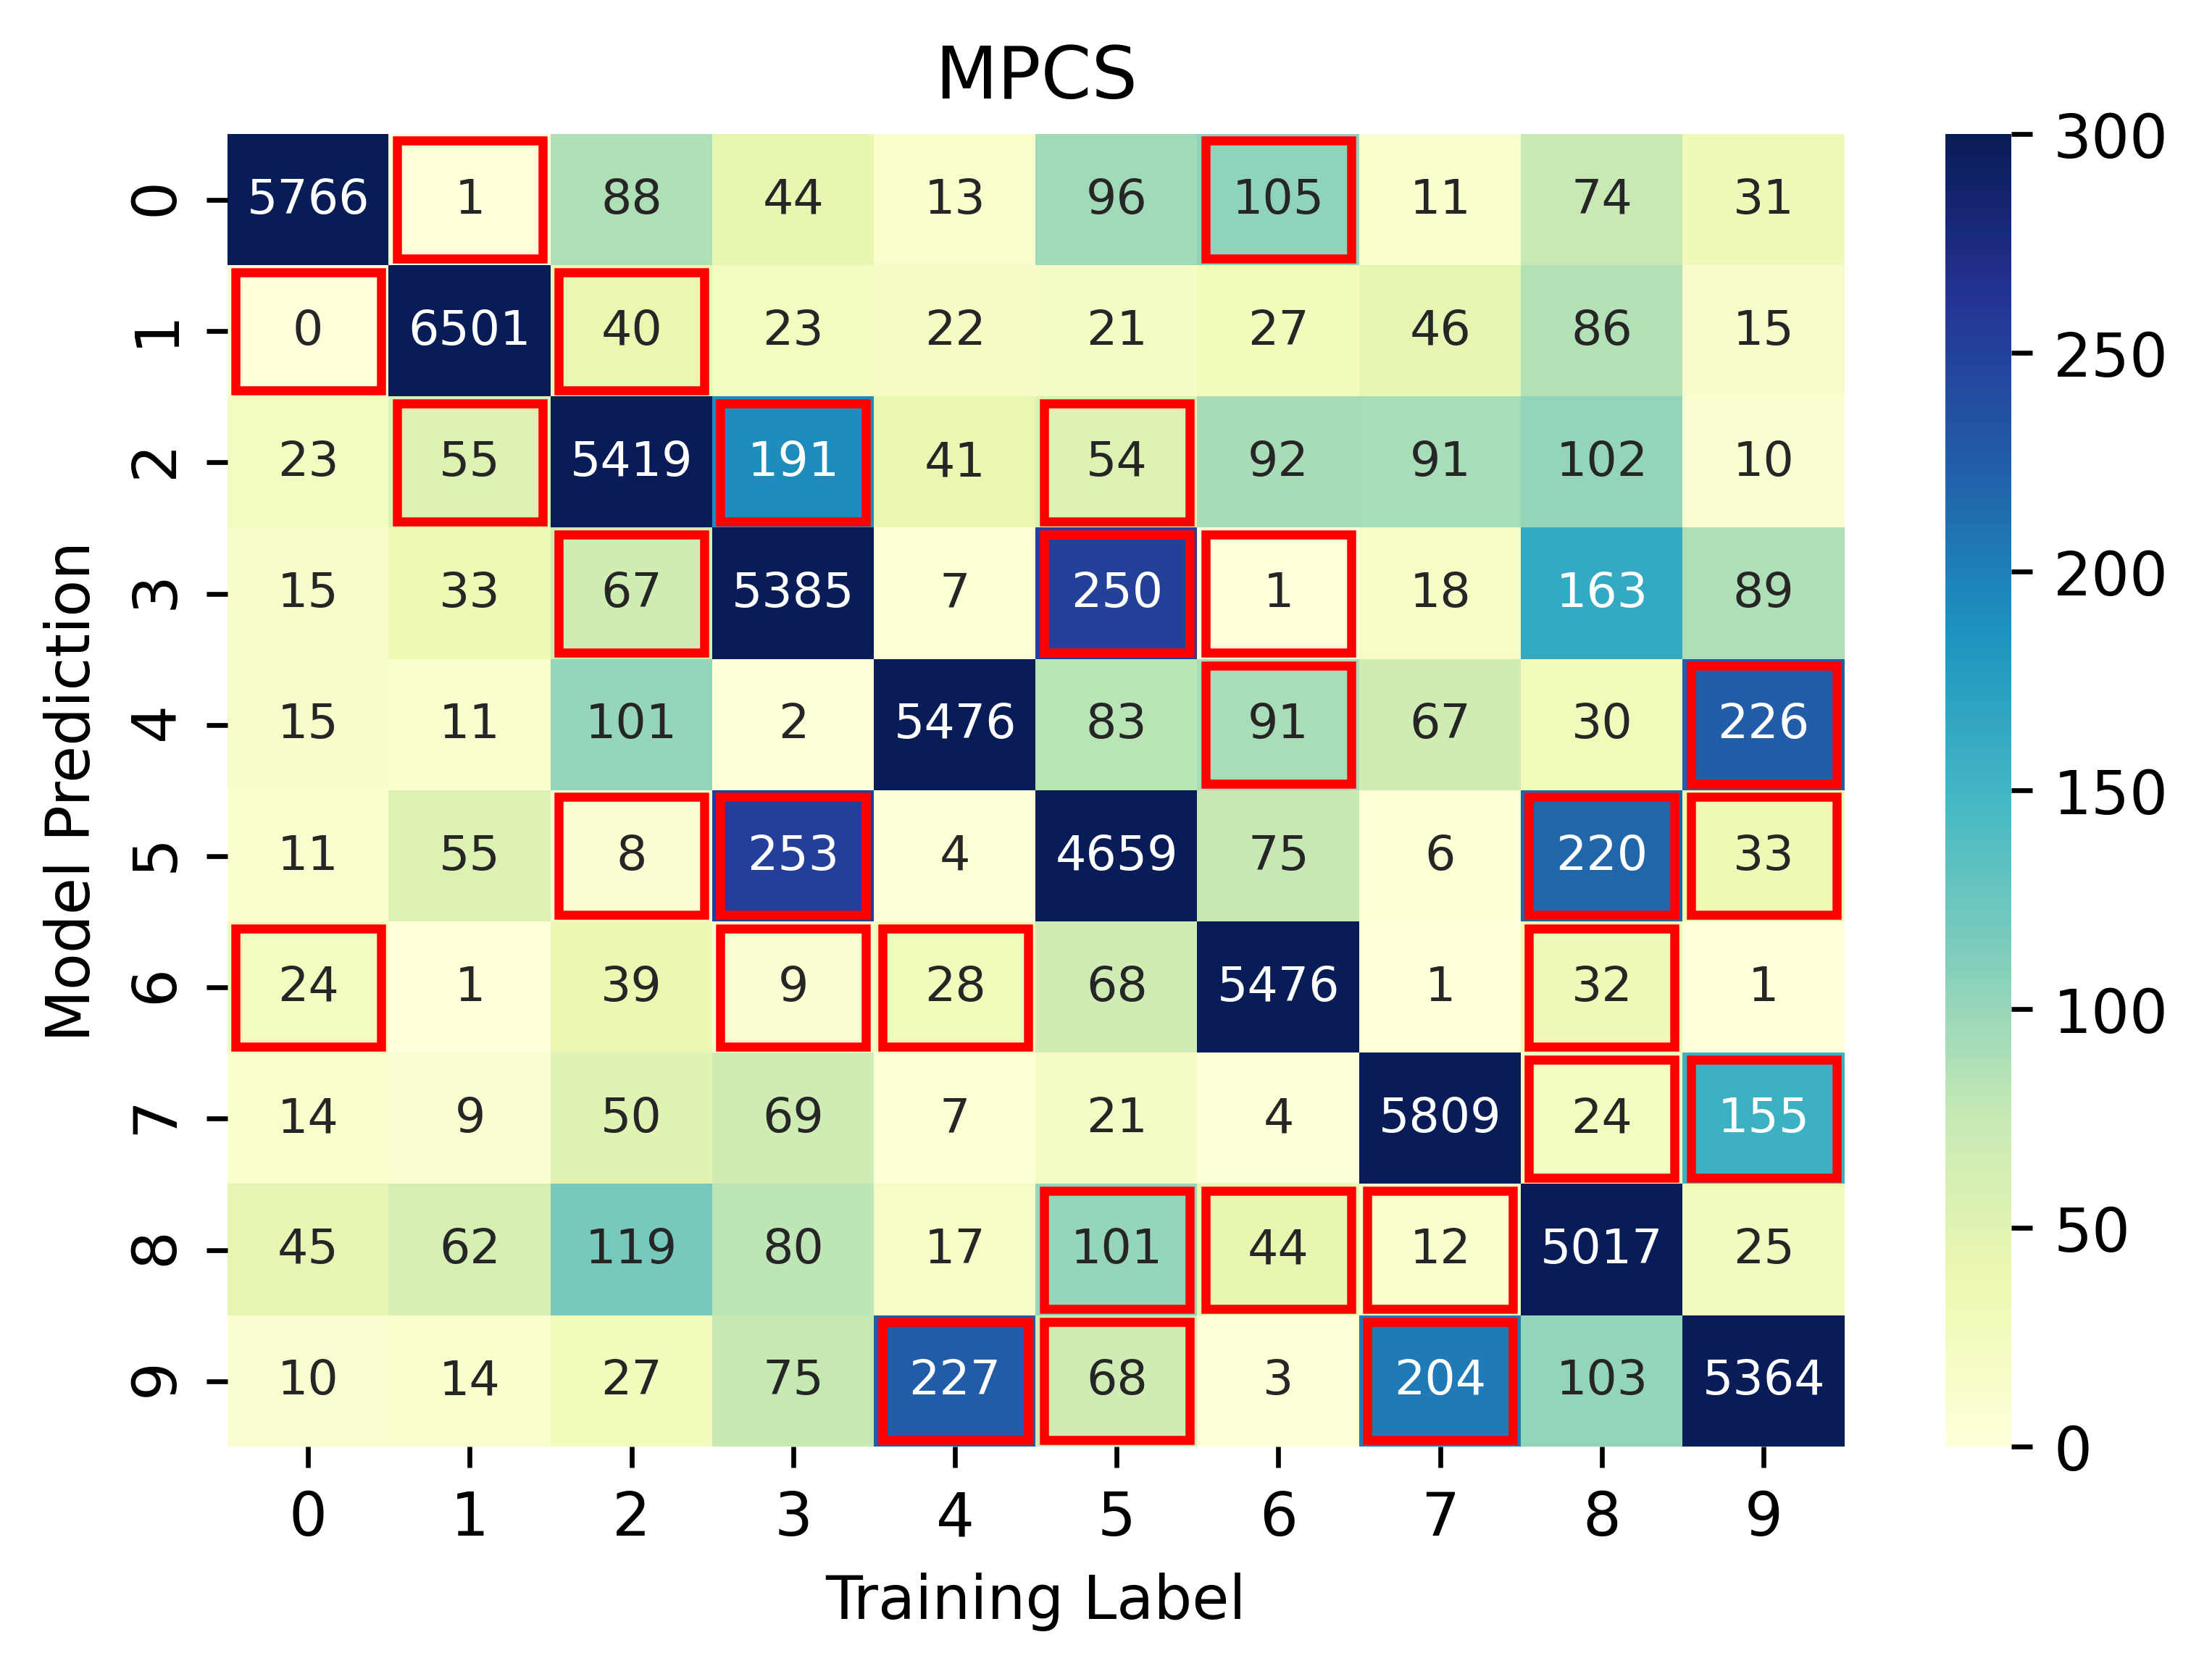

In [72]:
model = torch.load(f'../Records/{NAME}-133.pkl')  # 146  0.5  7  200

train_output = model(train_X)
pred_train_y = torch.max(train_output, 1)[1].data.numpy()

mt = np.zeros((10,10)).astype(int)
for i in range(len(pred_train_y)):
    xx = int(pred_train_y[i])
    yy = int(train_Y[i])
    mt[xx][yy] += 1

print(mt)


correct_num = 0
for i in range(10):
    correct_num += mt[i][i]
    
release_num = 0
for i in range(len(RELEASE_LISTS)):
    release_num += mt[RELEASE_LISTS[i][0]][RELEASE_LISTS[i][1]]
    
bad_num = len(pred_train_y) - correct_num - release_num

print('correct_num: ', correct_num)
print('release_num: ', release_num)
print('bad_num: ', bad_num)

train_output = model(train_X)
pred_train_y = torch.max(train_output, 1)[1].data.numpy()
train_accuracy = float((pred_train_y == train_Y).astype(int).sum()) / float(train_Y.size)
print('train_accuracy: ', train_accuracy)

test_output = model(test_X)
pred_test_y = torch.max(test_output, 1)[1].data.numpy()
test_accuracy = float((pred_test_y == test_Y).astype(int).sum()) / float(test_Y.size)
print('test_accuracy: ', test_accuracy)


import seaborn as sns

plt.figure(dpi=600)
ax = sns.heatmap(mt, cmap="YlGnBu", vmax=300, vmin=0, annot=True, annot_kws={'size':8}, fmt=".0f")

ax.set_title('MPCS')  # 图标题
ax.set_xlabel('Training Label')  # x轴标题
ax.set_ylabel('Model Prediction')

for item in RELEASE_LISTS:
    ax.add_patch(plt.Rectangle((item[0]+0.05, item[1]+0.05), 0.9, 0.9, facecolor="none", edgecolor="red", linewidth=1.5))

plt.savefig(f'../Records/heatmap-MPCS.jpg', dpi=600)  # 保存图片
plt.show()

# Heatmap

[[5777    1  105   49   16  113  112   11   81   33]
 [   0 6517   53   24   23   23   29   44   90   17]
 [  12   47 5338  165   33   45   53   71   72    9]
 [  13   32   67 5392    6  258    1   16  150   89]
 [  13   12  114    3 5516   85   80   67   35  280]
 [  10   52    6  244    4 4616   62    6  182   31]
 [  24    2   46    9   31   83 5527    2   39    1]
 [  18   11   67   82   17   27    5 5893   34  227]
 [  49   58  142   96   19  112   48   13 5092   38]
 [   7   10   20   67  177   59    1  142   76 5224]]
correct_num:  54892
release_num:  2487
bad_num:  2621
train_accuracy:  0.9148666666666667
test_accuracy:  0.916


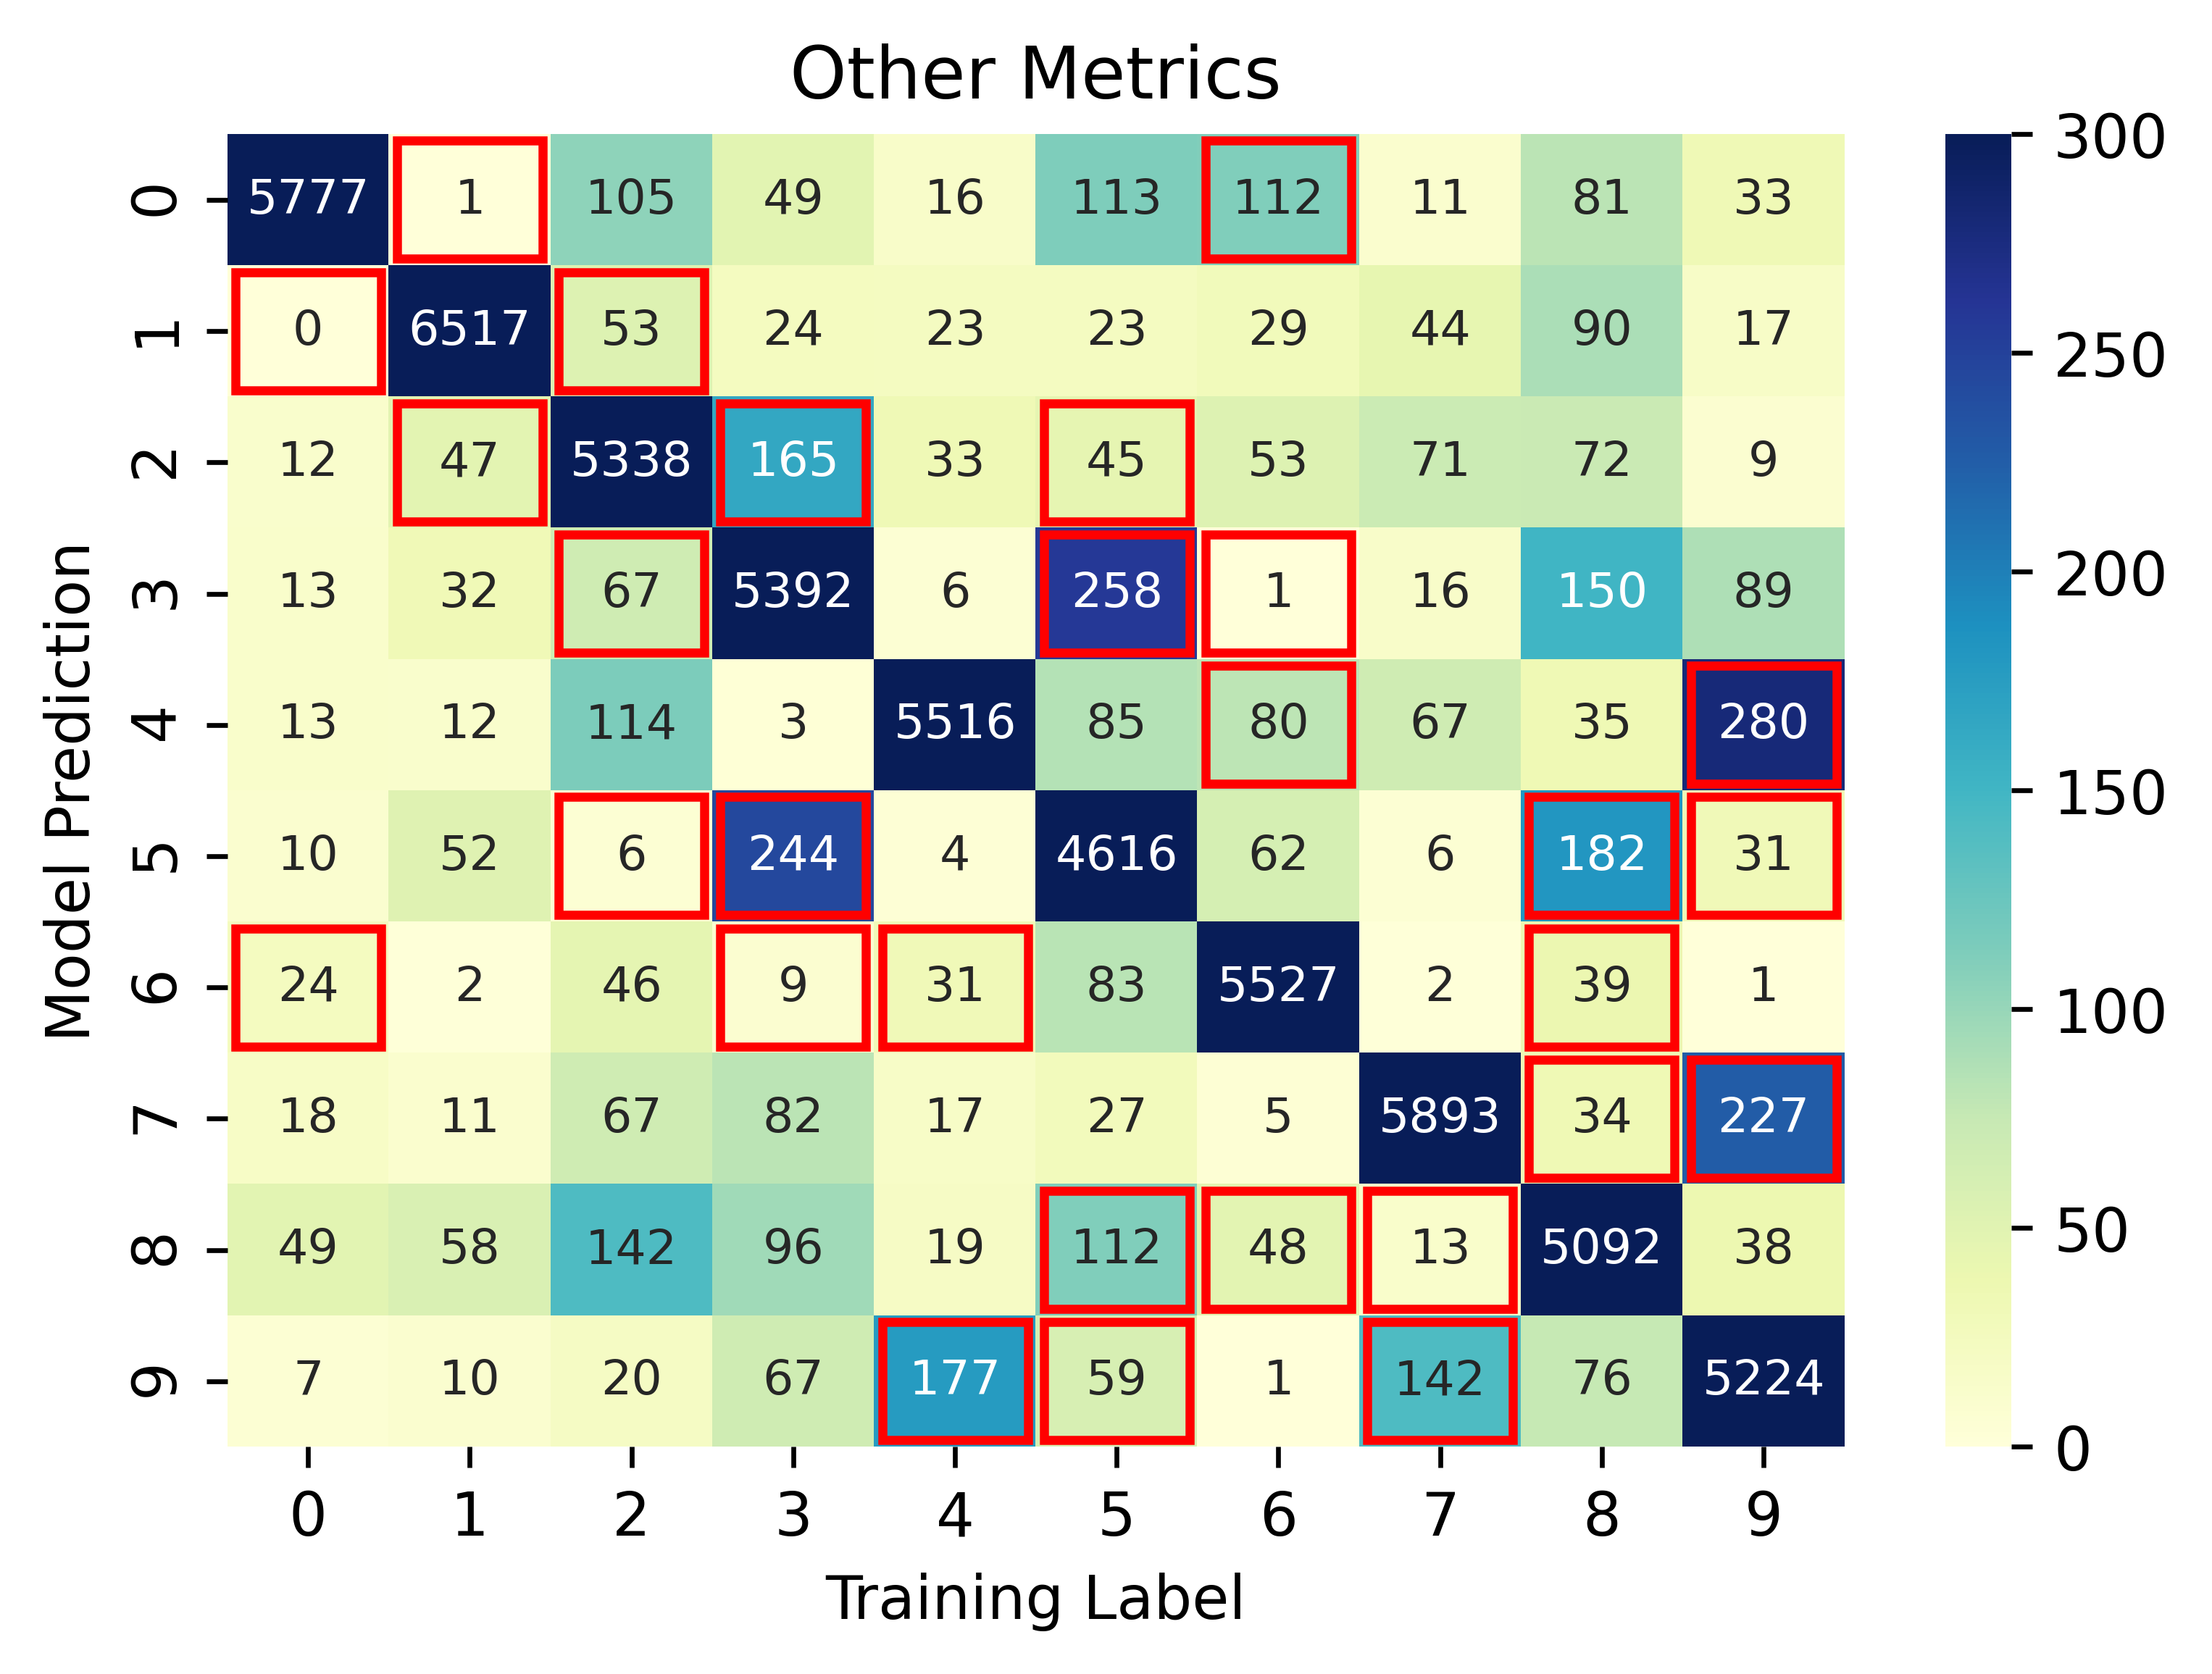

In [73]:
model = torch.load(f'../Records/{NAME}-132.pkl')

train_output = model(train_X)
pred_train_y = torch.max(train_output, 1)[1].data.numpy()

mt = np.zeros((10,10)).astype(int)
for i in range(len(pred_train_y)):
    xx = int(pred_train_y[i])
    yy = int(train_Y[i])
    mt[xx][yy] += 1

print(mt)


correct_num = 0
for i in range(10):
    correct_num += mt[i][i]
    
release_num = 0
for i in range(len(RELEASE_LISTS)):
    release_num += mt[RELEASE_LISTS[i][0]][RELEASE_LISTS[i][1]]
    
bad_num = len(pred_train_y) - correct_num - release_num

print('correct_num: ', correct_num)
print('release_num: ', release_num)
print('bad_num: ', bad_num)

train_output = model(train_X)
pred_train_y = torch.max(train_output, 1)[1].data.numpy()
train_accuracy = float((pred_train_y == train_Y).astype(int).sum()) / float(train_Y.size)
print('train_accuracy: ', train_accuracy)

test_output = model(test_X)
pred_test_y = torch.max(test_output, 1)[1].data.numpy()
test_accuracy = float((pred_test_y == test_Y).astype(int).sum()) / float(test_Y.size)
print('test_accuracy: ', test_accuracy)


import seaborn as sns

plt.figure(dpi=600)
ax = sns.heatmap(mt, cmap="YlGnBu", vmax=300, vmin=0, annot=True, annot_kws={'size':8}, fmt=".0f")

ax.set_title('Other Metrics')  # 图标题
ax.set_xlabel('Training Label')  # x轴标题
ax.set_ylabel('Model Prediction')

for item in RELEASE_LISTS:
    ax.add_patch(plt.Rectangle((item[0]+0.05, item[1]+0.05), 0.9, 0.9, facecolor="none", edgecolor="red", linewidth=1.5))

plt.savefig(f'../Records/heatmap-Others.jpg', dpi=600)  # 保存图片
plt.show()
# Heatmap